In [ ]:
%matplotlib inline
import pandas as pd
import visualization as vis
import numpy as np
import utils
import sklearn as sk

In [124]:
def augment_features(power_levels, covariates_names, original_data):
    augmented_data = original_data.copy().loc[:, covariates_names]
    powers = []
    for power_level in power_levels:
        powers += zip(covariates_names, [power_level] * len(covariates_names))
    interactions = [(covariates_names[i], covariates_names[j]) \
                    for i in range(len(covariates_names)) for j in range(i + 1, len(covariates_names))]
    for feature, power in powers:
        augmented_data = utils.polynomial_feature(augmented_data, feature, power)
        original_data = utils.polynomial_feature(original_data, feature, power)
    for term1, term2 in interactions:
        augmented_data = utils.interaction_terms(augmented_data, term1, term2, term1 + '_' + term2)
        original_data = utils.interaction_terms(original_data, term1, term2, term1 + '_' + term2)
    print(augmented_data.columns)
    return augmented_data, original_data


def lookup_best_alpha(augmented_data, y):
    selected_alpha = utils.lassoChoice(augmented_data.values, y)
    print(str(selected_alpha) + ' is the alpha parameter retained for Lasso')
    return selected_alpha


def lasso_pruning(alpha_parameter, augmented_data, y):
    features = list(augmented_data.columns)
    selected_lasso = sk.linear_model.Lasso(alpha=alpha_parameter)
    selected_lasso.fit(augmented_data.values, y)
    weights = selected_lasso.coef_
    features_to_drop = []
    for i, feature in enumerate(features):
        if weights[i] == 0:
            features_to_drop.append(feature)
    print(str(len(features_to_drop)) + ' features dropped out of ' + str(len(features)))
    return features_to_drop


def prune_features(features_to_drop, original_data):
    original_data.drop(columns=features_to_drop, inplace=True)
    return original_data


In [108]:
data = pd.read_pickle('./CleanedData/dataset_train.pkl')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76678 entries, 0 to 96039
Data columns (total 26 columns):
order_products_value          76678 non-null float64
order_freight_value           76678 non-null float64
order_items_qty               76678 non-null int64
product_description_lenght    76678 non-null int64
review_comment_message        76678 non-null float64
approval_time                 76678 non-null float64
delivery_delay                76678 non-null float64
review_time                   76678 non-null float64
lat                           76678 non-null float64
lng                           76678 non-null float64
seller_lat                    76678 non-null float64
seller_lng                    76678 non-null float64
product_weight_g              76678 non-null float64
product_length_cm             76678 non-null float64
product_height_cm             76678 non-null float64
product_width_cm              76678 non-null float64
review_score_1                76678 non-null in

### Classification Task

Target:review score

In [109]:
x = data.loc[:, ["review_score_1", "review_score_2", "review_score_3",
                 "review_score_4", "review_score_5"]].stack()
review_scores = pd.Series(pd.Categorical(x[x != 0].index.get_level_values(1)))
target = []
for i in range(len(review_scores)):
    n = review_scores[i][-1]
    target.append(int(n))
data = data.assign(target=target)
data.drop(columns=["review_score_1", "review_score_2", "review_score_3", "review_score_4", "review_score_5"],
          inplace=True)

/Users/sun/Desktop/Dev/R/MSE226/Project/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


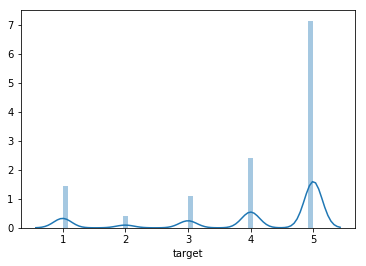

In [110]:
vis.histogram(data, "target")

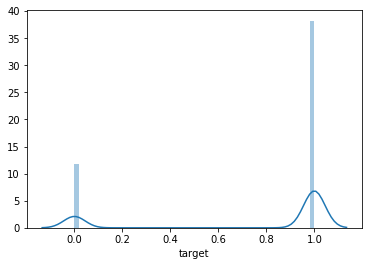

In [111]:
target = []
for i in data.loc[:, "target"]:
    if i >= 4:
        target.append(1)
    else:
        target.append(0)
data = data.assign(target=target)
vis.histogram(data, "target")

### Covariates groups
#### 1. Localization and transportation costs
- order_freight_value numeric
- product_weight_g numeric
- delivery_delay numeric
- lat numeric
- lng numeric
- seller_lat numeric
- seller_lng numeric
- order_products_value
- order_items_qty

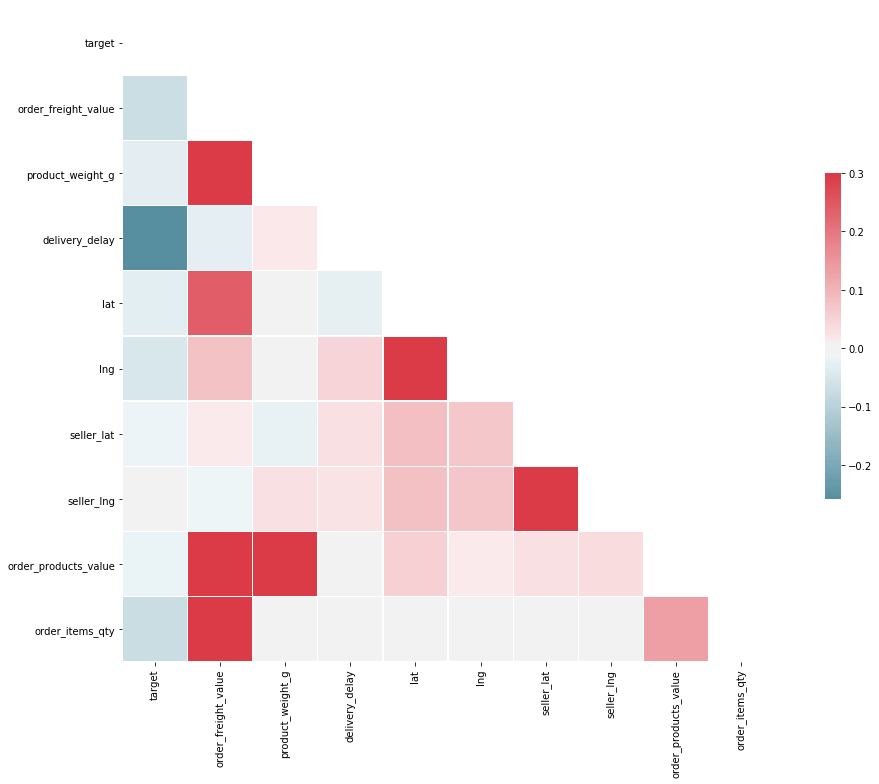

In [112]:
covariates_names = ['order_freight_value', 'product_weight_g', 'delivery_delay',
                    'lat', 'lng', 'seller_lat', 'seller_lng', 'order_products_value', 'order_items_qty']
vis.correlation_matrix(data.loc[:, ['target'] + covariates_names])

Computing regularization path using the coordinate descent lasso...


240.51065066981644 is the alpha parameter retained for Lasso


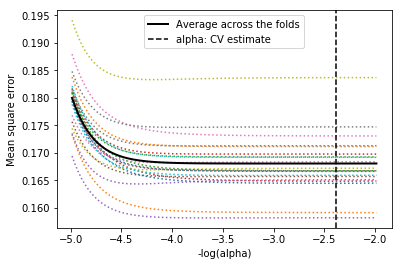

In [113]:
from FeaturesClassification import lookup_best_alpha
selected_alpha = lookup_best_alpha(data, data.loc[:, 'target'].values)

In [122]:
from FeaturesClassification import lasso_pruning

# alphas = np.linspace(start=0, stop= 1, num=100)
# for alpha in alphas:
#     features_to_drop = lasso_pruning(alpha, data, data.loc[:, 'target'].values)

features_to_drop = lasso_pruning(0.01, data, data.loc[:, 'target'].values)

for feature in list(data.columns):
    if feature in features_to_drop:
        continue
    else:
        print(feature)

13 features dropped out of 22
order_products_value
order_freight_value
product_description_lenght
review_comment_message
approval_time
delivery_delay
review_time
product_weight_g
target


Index(['order_freight_value', 'product_weight_g', 'delivery_delay', 'lat',
       'lng', 'seller_lat', 'seller_lng', 'order_products_value',
       'order_items_qty', 'order_freight_value_product_weight_g',
       'order_freight_value_delivery_delay', 'order_freight_value_lat',
       'order_freight_value_lng', 'order_freight_value_seller_lat',
       'order_freight_value_seller_lng',
       'order_freight_value_order_products_value',
       'order_freight_value_order_items_qty',
       'product_weight_g_delivery_delay', 'product_weight_g_lat',
       'product_weight_g_lng', 'product_weight_g_seller_lat',
       'product_weight_g_seller_lng', 'product_weight_g_order_products_value',
       'product_weight_g_order_items_qty', 'delivery_delay_lat',
       'delivery_delay_lng', 'delivery_delay_seller_lat',
       'delivery_delay_seller_lng', 'delivery_delay_order_products_value',
       'delivery_delay_order_items_qty', 'lat_lng', 'lat_seller_lat',
       'lat_seller_lng', 'lat_order_prod

191256.32510709966 is the alpha parameter retained for Lasso


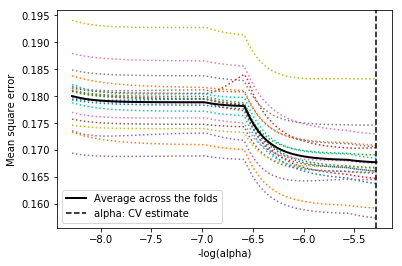

In [127]:
power_levels = []
augmented_data, data = augment_features(power_levels, covariates_names, data)
selected_alpha = lookup_best_alpha(augmented_data, data.loc[:, 'target'].values)

In [132]:
alphas = np.linspace(start=5, stop= selected_alpha, num=50)
for alpha in alphas:
    features_to_drop = lasso_pruning(alpha, augmented_data, data.loc[:, 'target'].values)
# features_to_drop = lasso_pruning(4000, augmented_data, data.loc[:, 'target'].values)
# 
# for feature in list(augmented_data.columns):
#     if feature in features_to_drop:
#         continue
#     else:
#         print(feature)


/Users/sun/Desktop/Dev/R/MSE226/Project/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


26 features dropped out of 45


36 features dropped out of 45


37 features dropped out of 45


38 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


39 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


40 features dropped out of 45


#### 2. Feedback
- review_time numeric
- review_comment_message numeric
- comment__False category
- comment__True category

In [ ]:
covariates_names = ['review_time', 'review_comment_message',
                    'comment__False', 'comment__True']
vis.correlation_matrix(data.loc[:,['log_target'] + covariates_names])

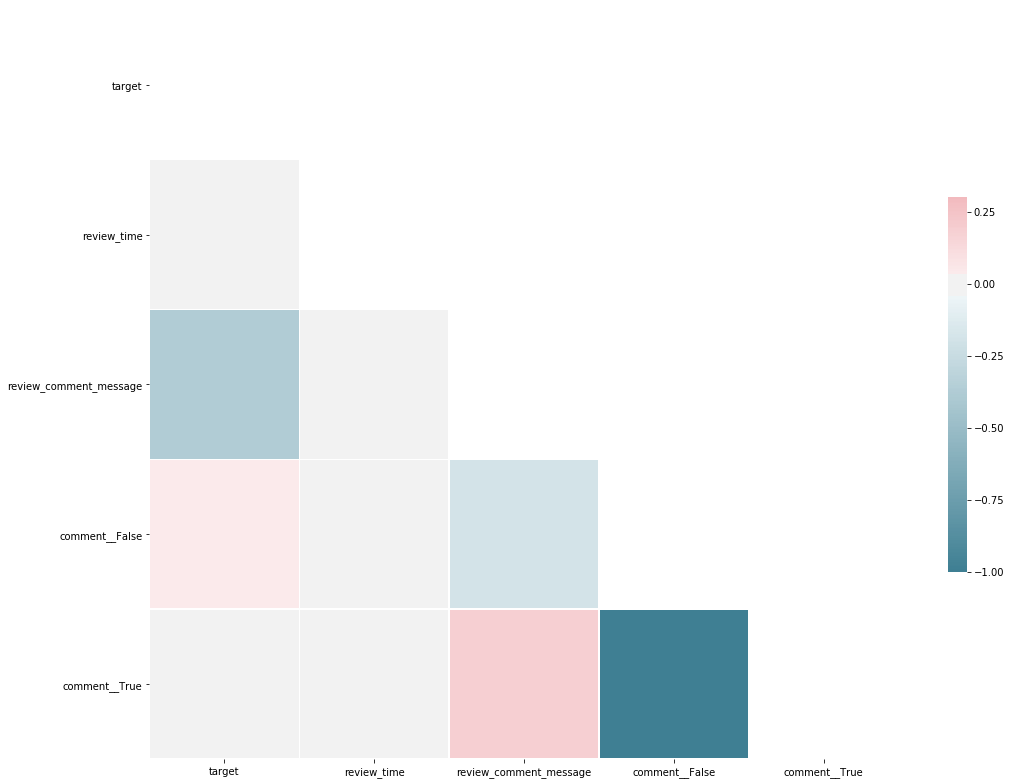

In [75]:
covariates_names = ['review_time', 'review_comment_message', 'comment__False', 'comment__True']
vis.correlation_matrix(data.loc[:, ['target'] + covariates_names])

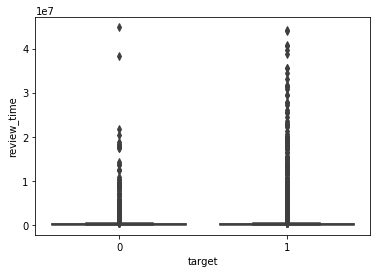

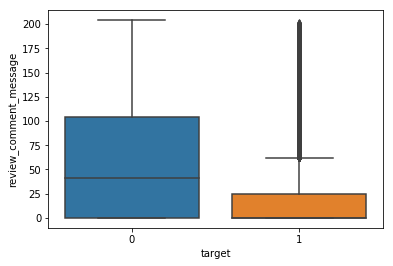

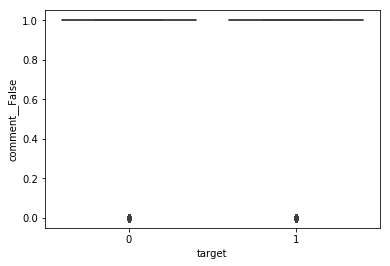

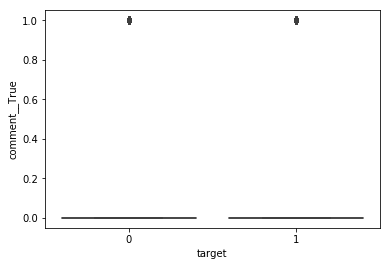

[None, None, None, None]

In [31]:
[vis.box_plots(data, 'target', cov_name) for cov_name in covariates_names]

#### 3. Care about product description
- product_description_lenght numeric
- product_photos_qty_0 category
- product_photos_qty_1 category
- product_photos_qty_2 category

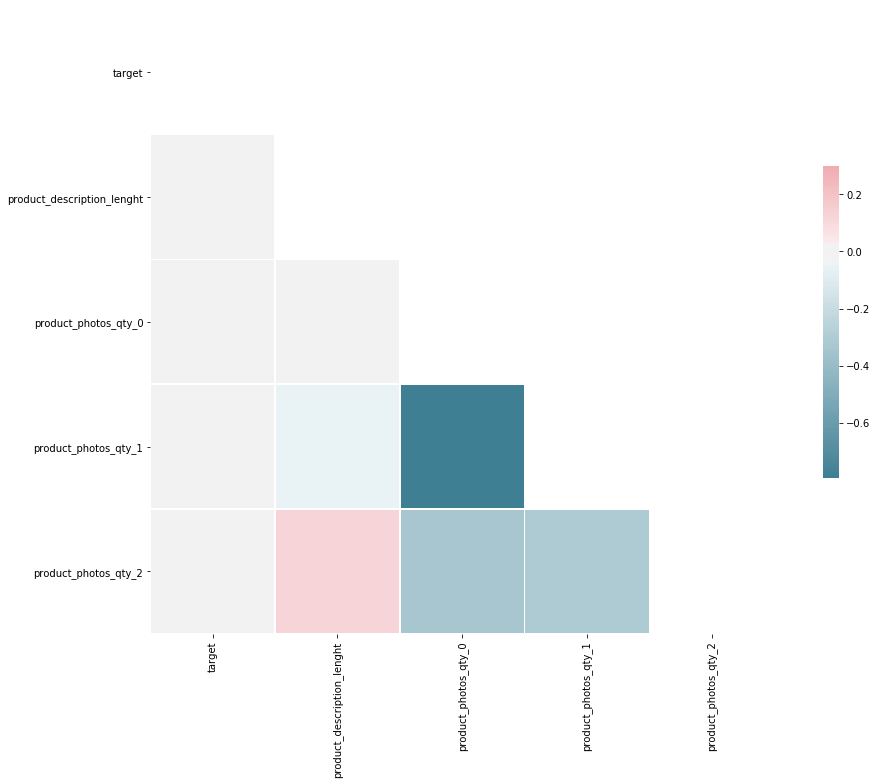

In [52]:
covariates_names = ['product_description_lenght', 'product_photos_qty_0', 
                    'product_photos_qty_1', 'product_photos_qty_2']
vis.correlation_matrix(data.loc[:, ['target'] + covariates_names])

#### 4. Product dimensions
- product_weight_g numeric
- product_length_cm numeric
- product_height_cm numeric
- product_width_cm numeric

#### 5. Processing time
- approval_time numeric
- delivery_delay numeric

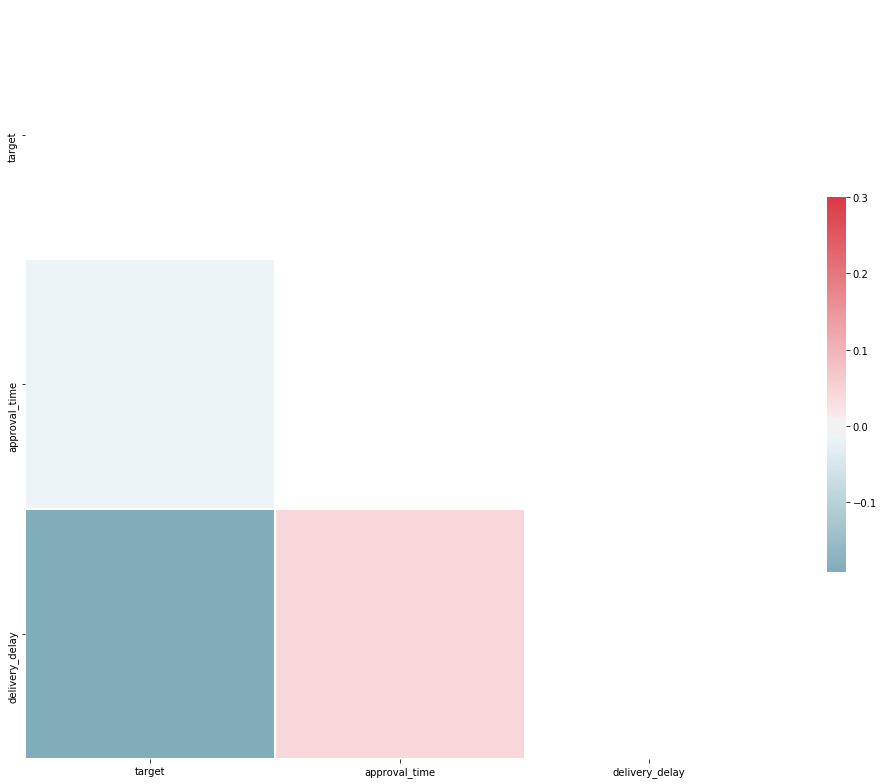

In [54]:
covariates_names = ['approval_time', 'delivery_delay']
vis.correlation_matrix(data.loc[:, ['target'] + covariates_names])